In [ ]:
!apt-get install -y p7zip-full


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
# Change this path to your file location
archive_path = "/content/augmented_data (2).zip"

# Extract to ./extracted directory
!7z x "{archive_path}" -o./extracted



7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 250295737 bytes (239 MiB)

Extracting archive: /content/augmented_data (2).zip
 56% 4096 Open              --
Path = /content/augmented_data (2).zip
Type = zip
Physical Size = 250295737

  0%      5% 514 - with_mask/aug_234.png                                  8% 863 - with_mask/aug_222.png                                 12% 1182 - with_mask/aug_1192.png                                   14% 1456 - with_mask/aug_1057.png

In [ ]:
import os
import time
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold


In [ ]:
# ------------ MODEL DEFINITION ------------
def create_model():
    base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(128, 128, 3))
    base_model.trainable = False  # Freeze feature extractor

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)

    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


In [ ]:
# Paths
with_mask_dir = "/content/extracted/with_mask"
without_mask_dir = "/content/extracted/without_mask"

# Lists
train_images = []
train_labels = []

# Size
newsize = (128, 128)

# Load "with_mask" images
for filename in os.listdir(with_mask_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        img = Image.open(os.path.join(with_mask_dir, filename)).convert("RGB")
        img = img.resize(newsize)
        img_arr = np.array(img)
        train_images.append(img_arr)
        train_labels.append(0)

# Load "without_mask" images
for filename in os.listdir(without_mask_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        img = Image.open(os.path.join(without_mask_dir, filename)).convert("RGB")
        img = img.resize(newsize)
        img_arr = np.array(img)
        train_images.append(img_arr)
        train_labels.append(1)


# Hyperparameter and Augmentation

Trial 20 Complete [00h 04m 28s]
val_accuracy: 0.9887359142303467

Best val_accuracy So Far: 0.9887359142303467
Total elapsed time: 01h 10m 29s

Best hyperparameters: {'units': 160, 'dropout': 0.4}

Manual batch size testing...

Testing batch size: 16


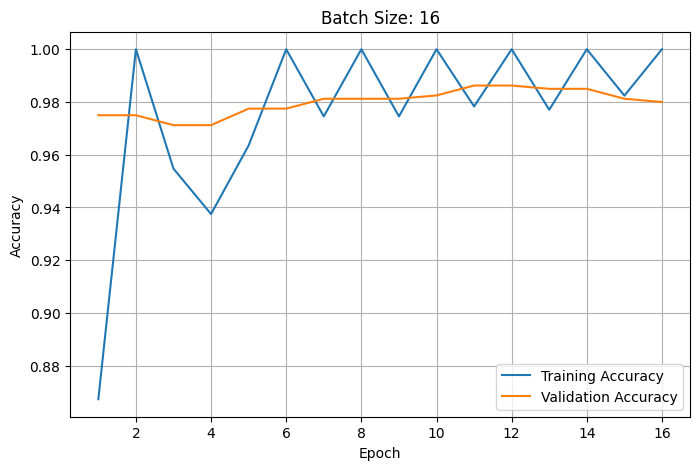

Batch 16: Max Val Acc = 0.9862 at Epoch 11

Testing batch size: 32


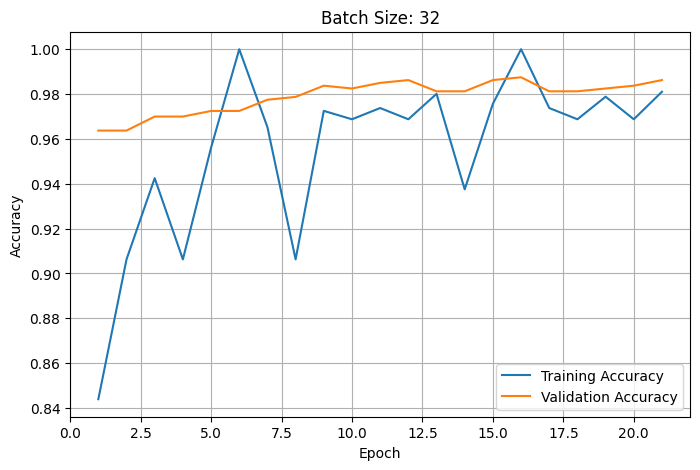

Batch 32: Max Val Acc = 0.9875 at Epoch 16

Testing batch size: 64


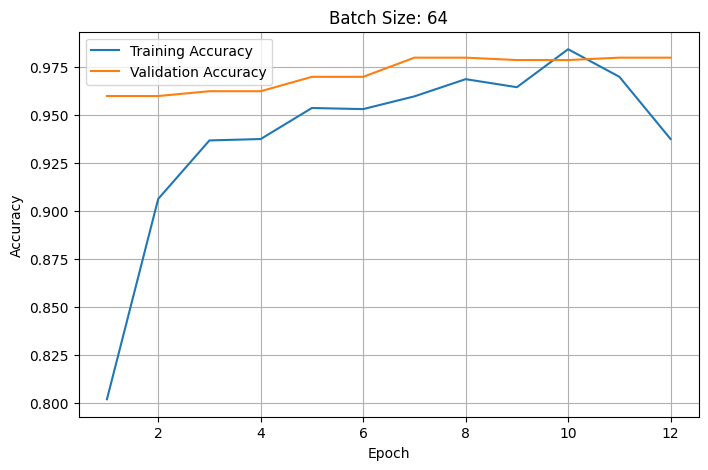

Batch 64: Max Val Acc = 0.9800 at Epoch 7

Testing batch size: 128


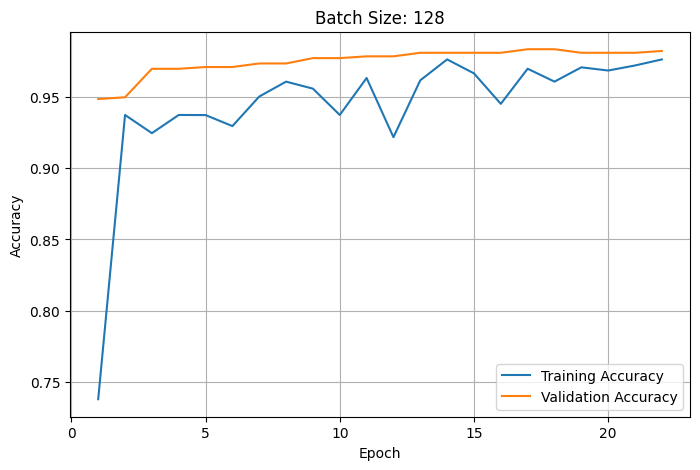

Batch 128: Max Val Acc = 0.9837 at Epoch 17

--- Final Results ---
Best Batch Size: 32
Best Epoch: 16
Best Validation Accuracy: 0.9875
Model saved as 'best_mobilenet_mask_detector_with_aug_save.keras'


In [ ]:
# Install keras-tuner
!pip install keras-tuner --quiet

# --- Imports ---
import os
import numpy as np
import random
from PIL import Image
from sklearn.model_selection import train_test_split
import keras_tuner as kt
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- Reproducibility ---
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)

# --- Paths ---
with_mask_dir = "/content/extracted/dataset/with_mask"
without_mask_dir = "/content/extracted/dataset/without_mask"
save_dir_original = "/content/saved_images/original"
save_dir_augmented = "/content/saved_images/augmented"

# Create directories to save images
for category in ["with_mask", "without_mask"]:
    os.makedirs(os.path.join(save_dir_original, category), exist_ok=True)
    os.makedirs(os.path.join(save_dir_augmented, category), exist_ok=True)

# --- Load Images ---
train_images = []
train_labels = []
newsize = (128, 128)

def load_and_save_images(src_dir, label, category):
    for filename in os.listdir(src_dir):
        if filename.lower().endswith(('.jpg', '.png')):
            img = Image.open(os.path.join(src_dir, filename)).convert("RGB")
            img = img.resize(newsize)
            img_arr = np.array(img)
            train_images.append(img_arr)
            train_labels.append(label)

            # Save original image
            save_path = os.path.join(save_dir_original, category, filename)
            img.save(save_path)

# Load and save
print("Loading 'with_mask' images...")
load_and_save_images(with_mask_dir, 0, "with_mask")

print("Loading 'without_mask' images...")
load_and_save_images(without_mask_dir, 1, "without_mask")

# --- Convert to numpy and normalize ---
train_images = np.array(train_images).astype('float32') / 255.0
train_labels = np.array(train_labels)

print(f"Total images loaded: {len(train_images)}")
print(f"Image shape: {train_images.shape}, Labels shape: {train_labels.shape}")

# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=random_seed, stratify=train_labels
)

# --- Define Model ---
def build_model(hp):
    base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(128, 128, 3))
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(hp.Int('units', 64, 256, step=32), activation='relu')(x)
    x = Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1))(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# --- EarlyStopping ---
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# --- Keras Tuner ---
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    directory='tuner_dir',
    project_name='mask_detector_tuning_with_aug_save'
)

tuner.search_space_summary()

# --- Augmentation & Save Augmented Images ---
aug_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Save augmented images to disk
print("\nSaving augmented images...")
for idx in range(len(X_train)):
    img = X_train[idx]
    label = y_train[idx]
    category = "with_mask" if label == 0 else "without_mask"

    img_batch = np.expand_dims(img, axis=0)
    aug_iter = aug_generator.flow(img_batch, batch_size=1, save_to_dir=os.path.join(save_dir_augmented, category),
                                  save_prefix=f"aug_{idx}", save_format="jpg")
    # Generate and save one augmented image per original image
    next(aug_iter)

# --- Keras Tuner Search ---
keras_tuner_flow_batch_size = 64
steps_per_epoch_tuner = len(X_train) // keras_tuner_flow_batch_size

aug_generator.fit(X_train)

print("\nStarting Keras Tuner search with data augmentation...")
tuner.search(
    aug_generator.flow(X_train, y_train, batch_size=keras_tuner_flow_batch_size),
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=2,
    steps_per_epoch=steps_per_epoch_tuner
)

# --- Best Hyperparameters ---
best_hp = tuner.get_best_hyperparameters(1)[0]
print(f"\nBest hyperparameters: {best_hp.values}")

# --- Manual Batch Size Testing ---
possible_batch_sizes = [16, 32, 64, 128]
best_acc, best_batch_size, best_epoch = 0, None, 0
best_model = None

print("\nManual batch size testing...")

for batch_size in possible_batch_sizes:
    print(f"\nTesting batch size: {batch_size}")
    model = build_model(best_hp)
    steps_per_epoch_manual = len(X_train) // batch_size

    history = model.fit(
        aug_generator.flow(X_train, y_train, batch_size=batch_size),
        validation_data=(X_test, y_test),
        epochs=50,
        callbacks=[early_stop],
        verbose=0,
        steps_per_epoch=steps_per_epoch_manual
    )

    val_acc = history.history['val_accuracy']
    train_acc = history.history['accuracy']
    epochs_range = range(1, len(train_acc)+1)

    plt.figure(figsize=(8,5))
    plt.plot(epochs_range, train_acc, label="Training Accuracy")
    plt.plot(epochs_range, val_acc, label="Validation Accuracy")
    plt.title(f"Batch Size: {batch_size}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    if val_acc:
        max_val_acc = max(val_acc)
        current_epoch = val_acc.index(max_val_acc) + 1
        print(f"Batch {batch_size}: Max Val Acc = {max_val_acc:.4f} at Epoch {current_epoch}")

        if max_val_acc > best_acc:
            best_acc = max_val_acc
            best_batch_size = batch_size
            best_epoch = current_epoch
            best_model = model

# --- Final Result ---
print("\n--- Final Results ---")
print(f"Best Batch Size: {best_batch_size}")
print(f"Best Epoch: {best_epoch}")
print(f"Best Validation Accuracy: {best_acc:.4f}")

if best_model:
    best_model.save("best_mobilenet_mask_detector_with_aug_save.keras")
    print("Model saved as 'best_mobilenet_mask_detector_with_aug_save.keras'")


In [ ]:
import cv2
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directory to save augmented images
save_augmented_dir = "/content/augmented_data"

# Create directories for each class
with_mask_aug_dir = os.path.join(save_augmented_dir, "with_mask")
without_mask_aug_dir = os.path.join(save_augmented_dir, "without_mask")
os.makedirs(with_mask_aug_dir, exist_ok=True)
os.makedirs(without_mask_aug_dir, exist_ok=True)

# Create ImageDataGenerator with augmentations
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Create a generator
augmented_data_generator = datagen.flow(
    X_train, y_train, batch_size=1, shuffle=False
)

print(f"Saving ALL augmented images to '{save_augmented_dir}'...")

saved_counts = {0: 0, 1: 0}

# Iterate over the generator until all data is augmented once
for i in range(len(augmented_data_generator)):
    img_batch, label_batch = next(augmented_data_generator)

    label = int(label_batch[0])
    img = img_batch[0]

    # De-normalize the image back to 0-255
    img = (img * 255).astype(np.uint8)

    # Choose directory based on label
    if label == 0:
        save_path = with_mask_aug_dir
    else:
        save_path = without_mask_aug_dir

    # Save image
    filename = f"aug_{saved_counts[label] + 1}.png"
    cv2.imwrite(os.path.join(save_path, filename), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

    saved_counts[label] += 1

print("✅ All augmented images saved successfully.")


NameError: name 'X_train' is not defined

In [ ]:
import shutil

shutil.make_archive("/content/augmented_data", 'zip', "/content/augmented_data")


'/content/augmented_data.zip'

In [ ]:
from google.colab import files

files.download("/content/augmented_data.zip")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Convert to numpy array
train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Remove images with wrong shape
valid_idx = [i for i, img in enumerate(train_images) if img.shape == (128,128,3)]
train_images = train_images[valid_idx]
train_labels = train_labels[valid_idx]

print("Total images:", train_images.shape[0])


Total images: 7188


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    train_images, train_labels, test_size=0.3, random_state=42
)


In [ ]:
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0


# K-Fold Code Complete


--- Training Fold 1 ---
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/16
126/126 ━━━━━━━━━━━━━━━━━━━━ 22s 94ms/step - accuracy: 0.7584 - loss: 0.4918 - val_accuracy: 0.9662 - val_loss: 0.1263
Epoch 2/16
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9540 - loss: 0.1488 - val_accuracy: 0.9722 - val_loss: 0.0880
Epoch 3/16
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9572 - loss: 0.1166 - val_accuracy: 0.9801 - val_loss: 0.0678
Epoch 4/16
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9728 - loss: 0.0832 - val_accuracy: 0.9772 - val_loss: 0.0610
Epoch 5/16
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9739 - loss: 0.0733 - val_accuracy: 0.9821 - val_loss: 0.0544
Epoch 6/16
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9817 - loss: 0.0586 - val_accuracy: 0.9821 - val_loss: 0.0517
Epoch 7/16
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9852 - loss: 0.0510 - val_accuracy: 0.9841 - val_loss: 0.0483
Epoch 8/16
126/126 ━━━

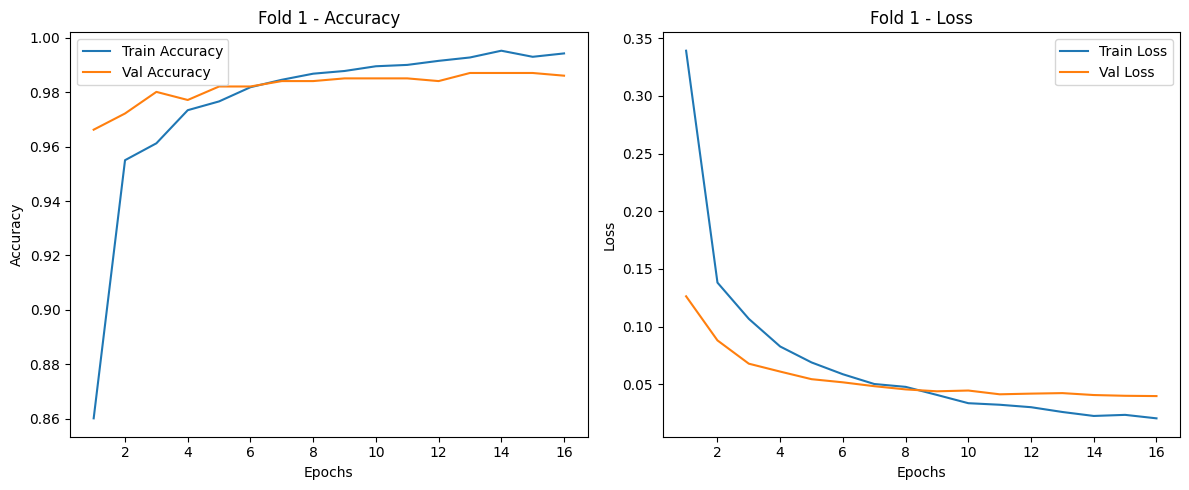


--- Training Fold 2 ---
Epoch 1/16
126/126 ━━━━━━━━━━━━━━━━━━━━ 20s 96ms/step - accuracy: 0.8270 - loss: 0.3924 - val_accuracy: 0.9513 - val_loss: 0.1420
Epoch 2/16
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9501 - loss: 0.1402 - val_accuracy: 0.9602 - val_loss: 0.0999
Epoch 3/16
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9701 - loss: 0.0954 - val_accuracy: 0.9742 - val_loss: 0.0808
Epoch 4/16
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9759 - loss: 0.0742 - val_accuracy: 0.9761 - val_loss: 0.0692
Epoch 5/16
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9778 - loss: 0.0720 - val_accuracy: 0.9751 - val_loss: 0.0643
Epoch 6/16
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9842 - loss: 0.0547 - val_accuracy: 0.9781 - val_loss: 0.0570
Epoch 7/16
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9837 - loss: 0.0501 - val_accuracy: 0.9821 - val_loss: 0.0549
Epoch 8/16
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9860

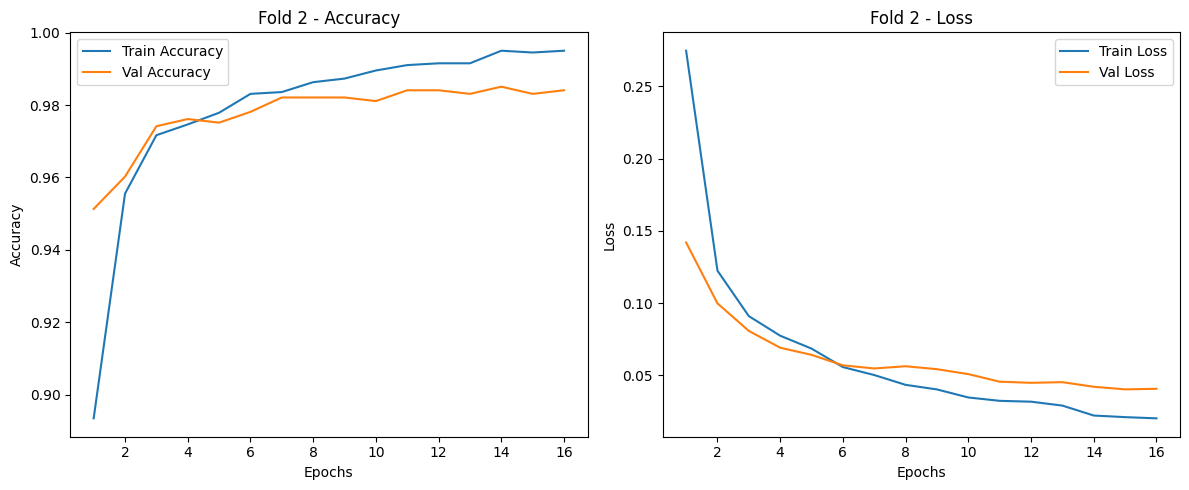


--- Training Fold 3 ---
Epoch 1/16
126/126 ━━━━━━━━━━━━━━━━━━━━ 17s 72ms/step - accuracy: 0.7936 - loss: 0.4343 - val_accuracy: 0.9523 - val_loss: 0.1556
Epoch 2/16
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9535 - loss: 0.1370 - val_accuracy: 0.9573 - val_loss: 0.1113
Epoch 3/16
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9711 - loss: 0.0978 - val_accuracy: 0.9622 - val_loss: 0.0956
Epoch 4/16
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9761 - loss: 0.0752 - val_accuracy: 0.9672 - val_loss: 0.0864
Epoch 5/16
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9809 - loss: 0.0629 - val_accuracy: 0.9712 - val_loss: 0.0778
Epoch 6/16
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9835 - loss: 0.0540 - val_accuracy: 0.9751 - val_loss: 0.0733
Epoch 7/16
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9891 - loss: 0.0443 - val_accuracy: 0.9751 - val_loss: 0.0694
Epoch 8/16
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9868

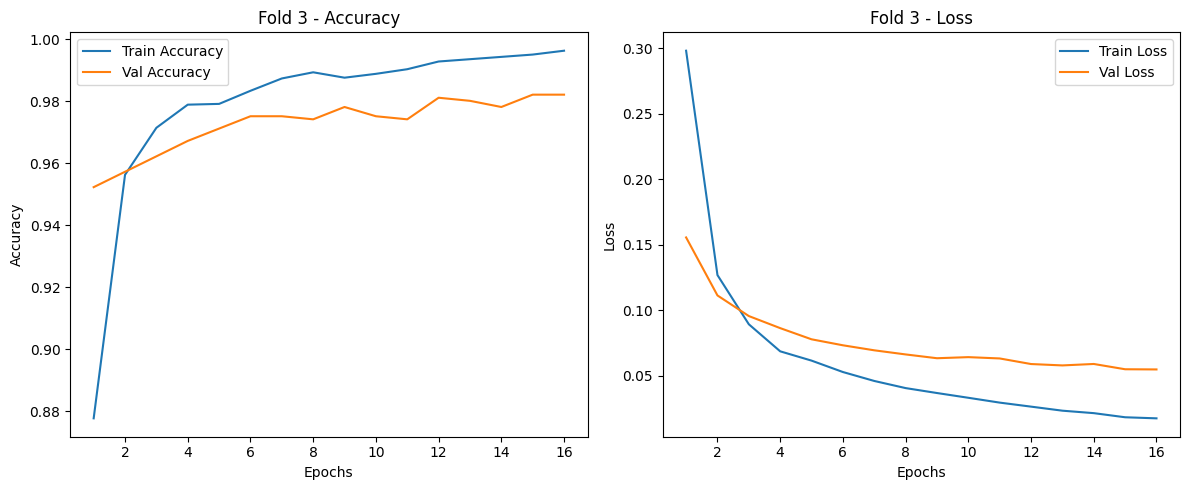


--- Training Fold 4 ---
Epoch 1/16
126/126 ━━━━━━━━━━━━━━━━━━━━ 19s 92ms/step - accuracy: 0.7314 - loss: 0.5483 - val_accuracy: 0.9662 - val_loss: 0.1425
Epoch 2/16
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9452 - loss: 0.1616 - val_accuracy: 0.9692 - val_loss: 0.0970
Epoch 3/16
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9660 - loss: 0.1031 - val_accuracy: 0.9781 - val_loss: 0.0786
Epoch 4/16
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9762 - loss: 0.0750 - val_accuracy: 0.9771 - val_loss: 0.0695
Epoch 5/16
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9722 - loss: 0.0767 - val_accuracy: 0.9801 - val_loss: 0.0620
Epoch 6/16
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9809 - loss: 0.0547 - val_accuracy: 0.9801 - val_loss: 0.0579
Epoch 7/16
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9834 - loss: 0.0484 - val_accuracy: 0.9791 - val_loss: 0.0549
Epoch 8/16
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9893

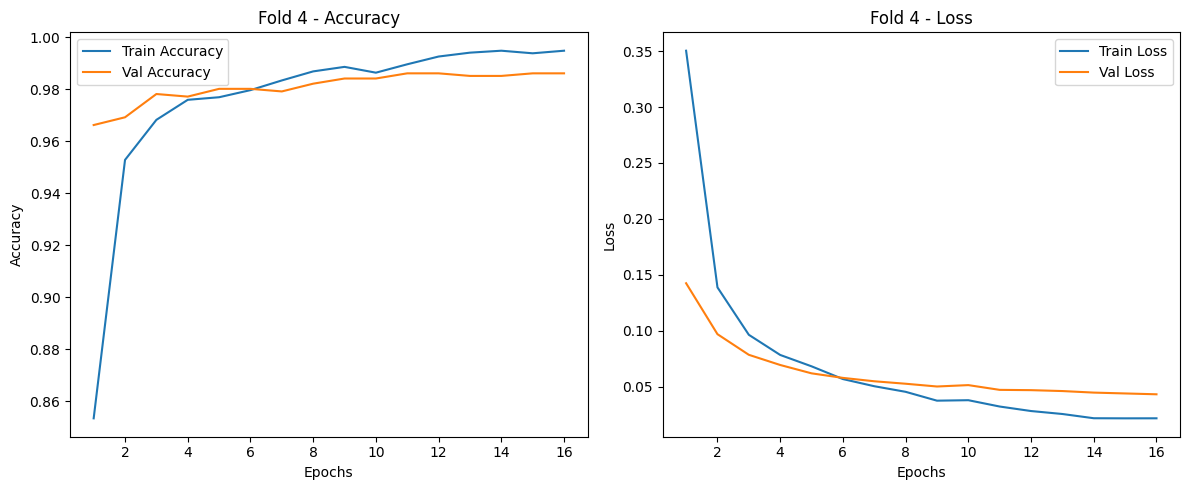


--- Training Fold 5 ---
Epoch 1/16
126/126 ━━━━━━━━━━━━━━━━━━━━ 18s 87ms/step - accuracy: 0.7030 - loss: 0.5349 - val_accuracy: 0.9583 - val_loss: 0.1444
Epoch 2/16
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9418 - loss: 0.1636 - val_accuracy: 0.9682 - val_loss: 0.0945
Epoch 3/16
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9593 - loss: 0.1095 - val_accuracy: 0.9751 - val_loss: 0.0735
Epoch 4/16
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9706 - loss: 0.0874 - val_accuracy: 0.9811 - val_loss: 0.0625
Epoch 5/16
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9787 - loss: 0.0686 - val_accuracy: 0.9831 - val_loss: 0.0560
Epoch 6/16
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9861 - loss: 0.0556 - val_accuracy: 0.9841 - val_loss: 0.0515
Epoch 7/16
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9853 - loss: 0.0514 - val_accuracy: 0.9861 - val_loss: 0.0490
Epoch 8/16
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.986

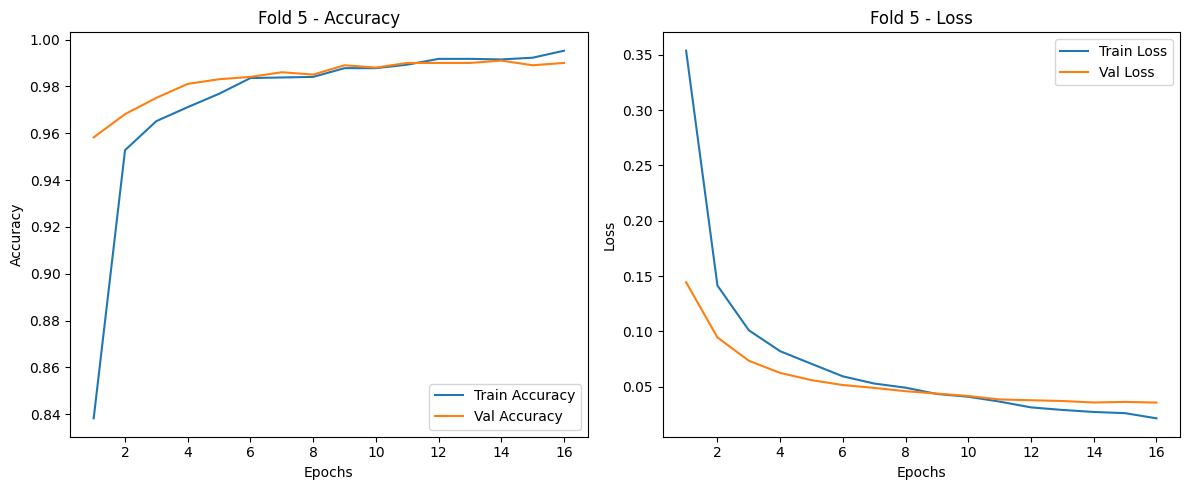

In [ ]:
# ------------ PLOTTING FUNCTION ------------
def plot_history(history, fold_num):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.title(f'Fold {fold_num} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.title(f'Fold {fold_num} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
histories = []

fold = 1
for train_idx, val_idx in kf.split(X_train):
    print(f"\n--- Training Fold {fold} ---")

    # Split data
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    # Create and train model
    model = create_model()
    history = model.fit(
        X_tr, y_tr,
        epochs=16,
        batch_size=32,
        validation_data=(X_val, y_val),
        verbose=1
    )

    # Save history & plot
    histories.append(history)
    plot_history(history, fold)

    fold += 1


In [ ]:
history = model.fit(
      X_train, y_train,
      epochs=16,
      batch_size=32,
      validation_data=(X_test, y_test)
  )

Epoch 1/16
158/158 ━━━━━━━━━━━━━━━━━━━━ 30s 194ms/step - accuracy: 1.0000 - loss: 8.8722e-05 - val_accuracy: 0.9977 - val_loss: 0.0137
Epoch 2/16
158/158 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9983 - loss: 0.0039 - val_accuracy: 0.9963 - val_loss: 0.0122
Epoch 3/16
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9985 - loss: 0.0041 - val_accuracy: 0.9917 - val_loss: 0.0399
Epoch 4/16
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9980 - loss: 0.0075 - val_accuracy: 0.9977 - val_loss: 0.0123
Epoch 5/16
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 1.0000 - loss: 4.1033e-04 - val_accuracy: 0.9981 - val_loss: 0.0096
Epoch 6/16
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9969 - loss: 0.0101 - val_accuracy: 0.9935 - val_loss: 0.0542
Epoch 7/16
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9993 - loss: 0.0021 - val_accuracy: 0.9879 - val_loss: 0.1098
Epoch 8/16
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9996 - loss: 0.0

In [ ]:
import matplotlib.pyplot as plt

# Extract accuracy and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs_range = range(1, len(acc) + 1)

# Plot the graph
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='s')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


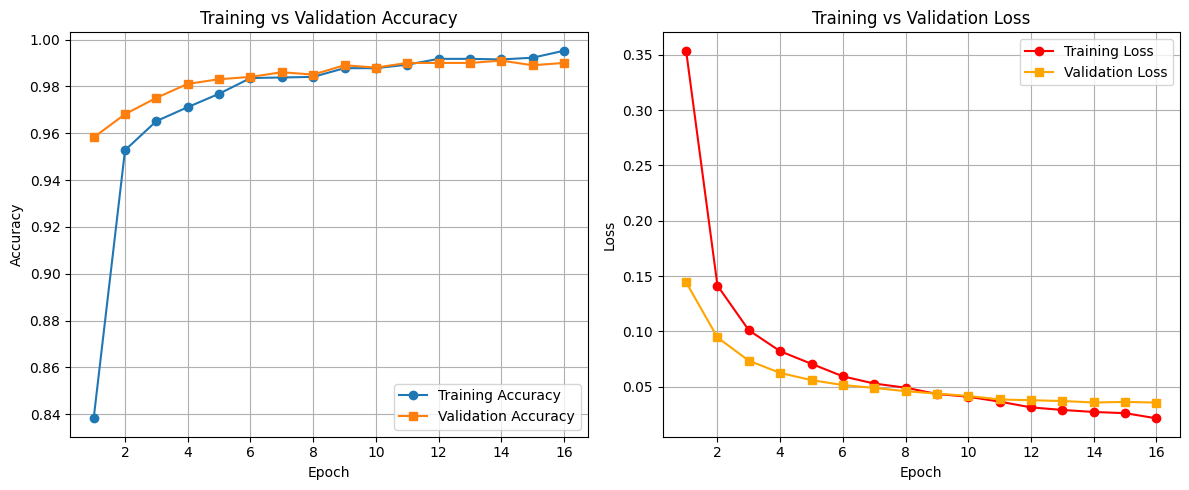

In [ ]:
import matplotlib.pyplot as plt

# Extract accuracy, validation accuracy, loss, and validation loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='s')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o', color='red')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='s', color='orange')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)


68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9883 - loss: 0.0415
Test Accuracy: 0.9893370270729065


In [ ]:
model.save("mask_detection_mobilenetv2.h5")

# Predicting on Batch and Calculating Avg time

In [ ]:
# Timing variables
num_samples = len(X_test)
total_time = 0.0

# Loop over all test images
for i in range(num_samples):
    img = np.expand_dims(X_test[i], axis=0)

    start_time = time.time()
    pred = model.predict(img)
    end_time = time.time()

    inference_time = end_time - start_time
    total_time += inference_time

    # If you want to see predictions:
    label = "Mask" if pred[0][0] < 0.5 else "No Mask"
    print(f"Image {i+1}: Prediction={label}, Time={inference_time:.6f} sec")

# Compute average inference time
average_time = total_time / num_samples
print(f"\nAverage inference time per image: {average_time:.6f} sec")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Image 1: Prediction=No Mask, Time=0.108784 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Image 2: Prediction=No Mask, Time=0.070367 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Image 3: Prediction=No Mask, Time=0.073083 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Image 4: Prediction=Mask, Time=0.069031 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Image 5: Prediction=Mask, Time=0.067815 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Image 6: Prediction=No Mask, Time=0.105250 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Image 7: Prediction=No Mask, Time=0.107009 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Image 8: Prediction=Mask, Time=0.071771 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Image 9: Prediction=Mask, Time=0.073821 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Image 10: Prediction=No Mask, Time=0.072419 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Image 11: Prediction=Mask, Time=0.107081 sec
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Im

# Converting to tflite

In [ ]:
import tensorflow as tf

# Load your trained Keras model
model = tf.keras.models.load_model("mask_detection_mobilenetv2.h5")

# Create converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# OPTIONAL: Enable optimization for size and speed
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# OPTIONAL: If you want INT8 quantization (smallest & fastest), you also need to set a representative dataset.
# For simplicity, here we keep FP16/FP32. Let me know if you want full INT8 code.

# Convert model
tflite_model = converter.convert()

# Save to file
with open("mobilenet_mask_detector.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ TFLite model saved as mobilenet_mask_detector.tflite")


Saved artifact at '/tmp/tmp2h4thvuy'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer_4')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  137901944067792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137901944078160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137901944072976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137901944077968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137901944074512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137901936299664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137901936299472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137901936297744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137901936297360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137901936301968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1379019362965

# Adding INT8 Qunatization

In [ ]:
# ================================
# 🚀 1) Load Keras Model
# ================================
import tensorflow as tf

model = tf.keras.models.load_model("mask_detection_mobilenetv2.h5")

# ================================
# 🚀 2) Create Representative Dataset
# ================================
# Make sure X_train exists and is preprocessed
# If not, you can create dummy data like this:
# X_train = np.random.rand(100,128,128,3).astype("float32")
# But ideally you should use your actual training data.

def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(X_train).batch(1).take(100):
        yield [tf.cast(input_value, tf.float32)]

# ================================
# Convert to INT8 TFLite
# ================================
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_quant_model = converter.convert()

# Save the model
with open("mobilenet_mask_detector_int8.tflite", "wb") as f:
    f.write(tflite_quant_model)

print("✅ INT8 quantized model saved.")

# ================================
# 🚀 4) Load TFLite Model (CPU)
# ================================
import numpy as np
from PIL import Image
import time

interpreter = tf.lite.Interpreter(model_path="mobilenet_mask_detector_int8.tflite")
interpreter.allocate_tensors()
print("✅ Loaded INT8 TFLite model with CPU interpreter.")

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# ================================
# 🚀 5) Single Image Prediction Function
# ================================
def predict_single_image(image_path):
    # Load & preprocess
    img = Image.open(image_path).convert("RGB")
    img = img.resize((128,128))
    img_array = np.array(img)

    # Quantize input to uint8
    input_scale, input_zero_point = input_details[0]['quantization']
    img_array = img_array / 255.0
    img_array = img_array / input_scale + input_zero_point
    img_array = img_array.astype(np.uint8)
    img_array = np.expand_dims(img_array, axis=0)

    # Warm-up
    interpreter.set_tensor(input_details[0]['index'], img_array)
    interpreter.invoke()

    # Timing
    start = time.time()
    interpreter.set_tensor(input_details[0]['index'], img_array)
    interpreter.invoke()
    end = time.time()

    # Get output
    output_data = interpreter.get_tensor(output_details[0]['index'])
    output_scale, output_zero_point = output_details[0]['quantization']
    prob = (output_data[0][0] - output_zero_point) * output_scale

    label = "Mask" if prob < 0.5 else "No Mask"

    print("\nPrediction:", label)
    print("Probability: {:.4f}".format(prob))
    print("Inference Time: {:.6f} sec\n".format(end - start))
    print("Raw probability value:", prob)
# ================================
# 🚀 6) Example Usage
# ================================
image_path = input("Enter the path to your test image: ")
predict_single_image(image_path)



Saved artifact at '/tmp/tmp67vv9qij'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer_4')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  137901794246096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137901794244944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137901794244560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137901794244752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137901794241296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137901794243408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137901794243024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137901794242640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137901794242832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137901794245520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1379017942391

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


✅ INT8 quantized model saved.
✅ Loaded INT8 TFLite model with CPU interpreter.
Enter the path to your test image: /content/download.jpg

Prediction: Mask
Probability: 0.0078
Inference Time: 0.005138 sec

Raw probability value: 0.0078125
